#segmentationのサンプルコード

*   オリジナルのデータで転移学習したノートブックです
*   githubに公開しているtraning_segmentationファイルをダウンロードしている方はそのまま実行できます
*   





labelmeでオリジナルデータを作った方は、データ内の画像を入れ替えれば転用できます

## segmentation_modelsをインストールする

In [5]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 8.3 MB/s 


## ドライブをマウントする

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## データのあるディレクトリまで移動します

In [23]:
cd /content/drive/MyDrive/training-segmentation/data/

/content/drive/MyDrive/training-segmentation/data


## 以下のようになっていればOK

In [24]:
ls

class_names.txt  SegmentationClass/     SegmentationClassVisualization/
JPEGImages/      SegmentationClassPNG/  tmp/


In [11]:
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import segmentation_models as sm

from PIL import Image
from tensorflow.python.keras.utils import np_utils
from sklearn.model_selection import train_test_split

sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

## データセットの準備

In [12]:
#データセット-インプット画像のサイズ
x_image_size = 480 
y_image_size = 320

x = []
y = []
#画像データを呼び出す
dir ="JPEGImages"
files = glob.glob(dir+"/*.jpg")
files.sort()
for i, file in enumerate(files): 
    image = Image.open(file) #画像の読み込み
    image = image.convert("RGB") #RGBに変換
    image = image.resize((x_image_size, y_image_size)) #サイズ変更
    data = np.asarray(image) #画像データを配列へ変更
    x.append(data) #画像データを繰返し追加
x = np.array(x)

#アノテーションデータ（マスクデータ）
dir ="SegmentationClassPNG"
files = glob.glob(dir+"/*.png")
files.sort()

for i, file in enumerate(files): 
    image = Image.open(file) #画像の読み込み
    image = image.convert("P") #パレットモード（インデックスカラー）へ変換
    image = image.resize((x_image_size, y_image_size)) #サイズ変更
    data = np.asarray(image) #画像データを配列へ変更
    y.append(data) #画像データを繰返し追加
y = np_utils.to_categorical(y, 2)
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, random_state=42)

In [13]:
print(f'x_train:{x_train.shape}, x_valid:{x_valid.shape},\ny_train:{y_train.shape}, y_valid:{y_valid.shape}')

x_train:(14, 320, 480, 3), x_valid:(5, 320, 480, 3),
y_train:(14, 320, 480, 2), y_valid:(5, 320, 480, 2)


## 準備したデータセットを確認する

In [14]:
def visualize(**images):
    """学習に使用するデータを可視化する関数
    input : ndarray
    output: 画像表示"""
    n = len(images)
    plt.figure(figsize=(32, 16))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

## Trainに使うデータ（2枚だけ表示する）

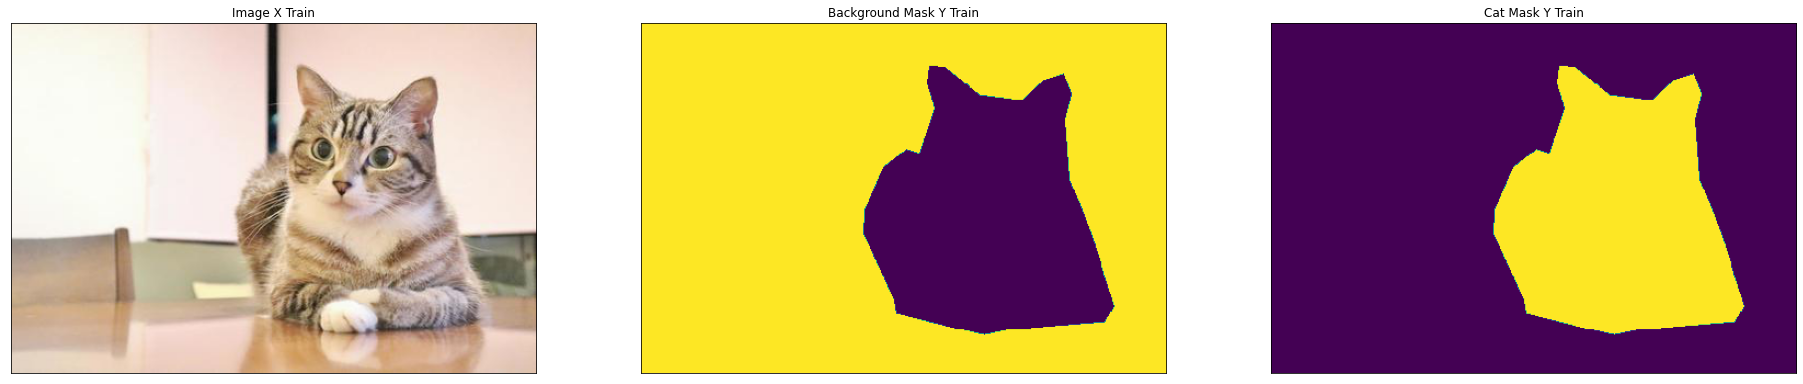

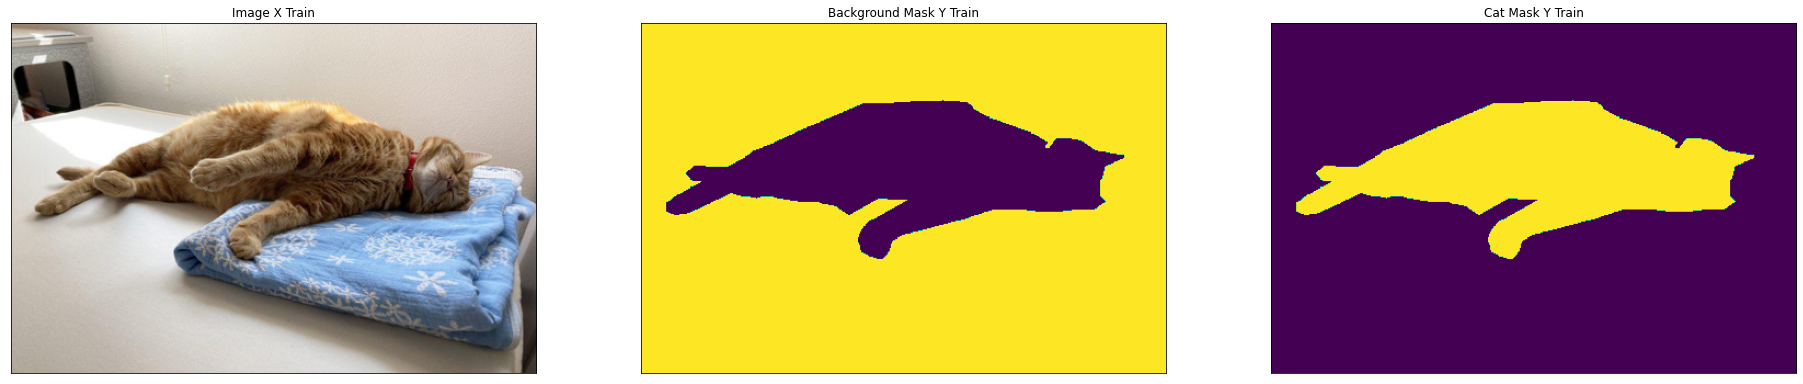

In [20]:
for i in range(0, 2):
  mask = y_train[i] # get some sample
  visualize(
      image_x_train = x_train[i], 
      background_mask_y_train = mask[..., 0].squeeze(),
      cat_mask_y_train = mask[..., 1].squeeze(),
  )

## Validに使うデータ（2枚だけ表示する）

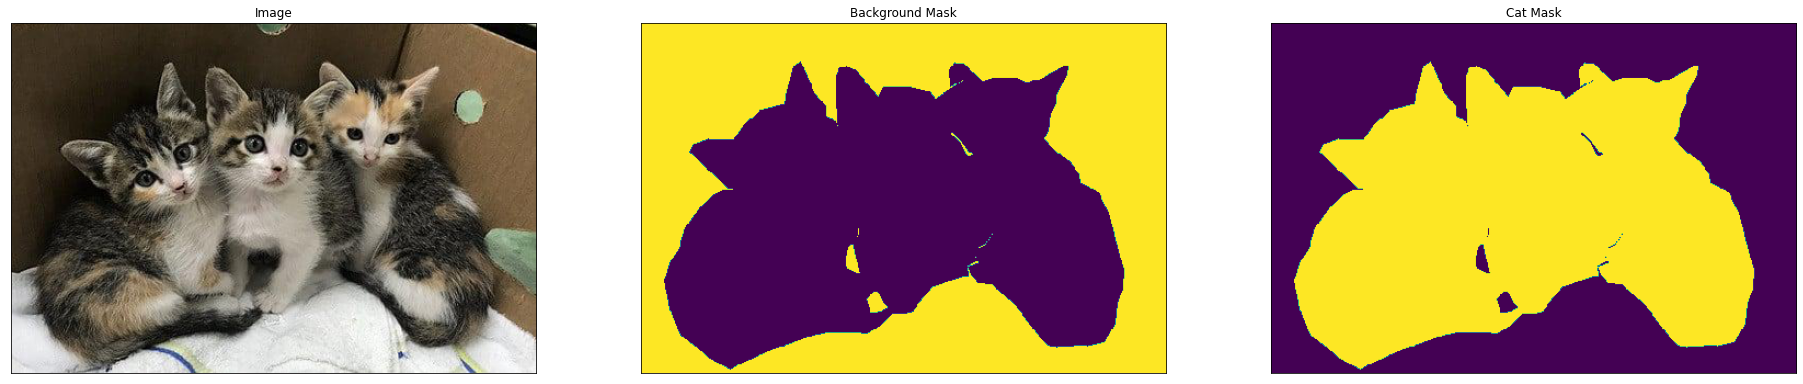

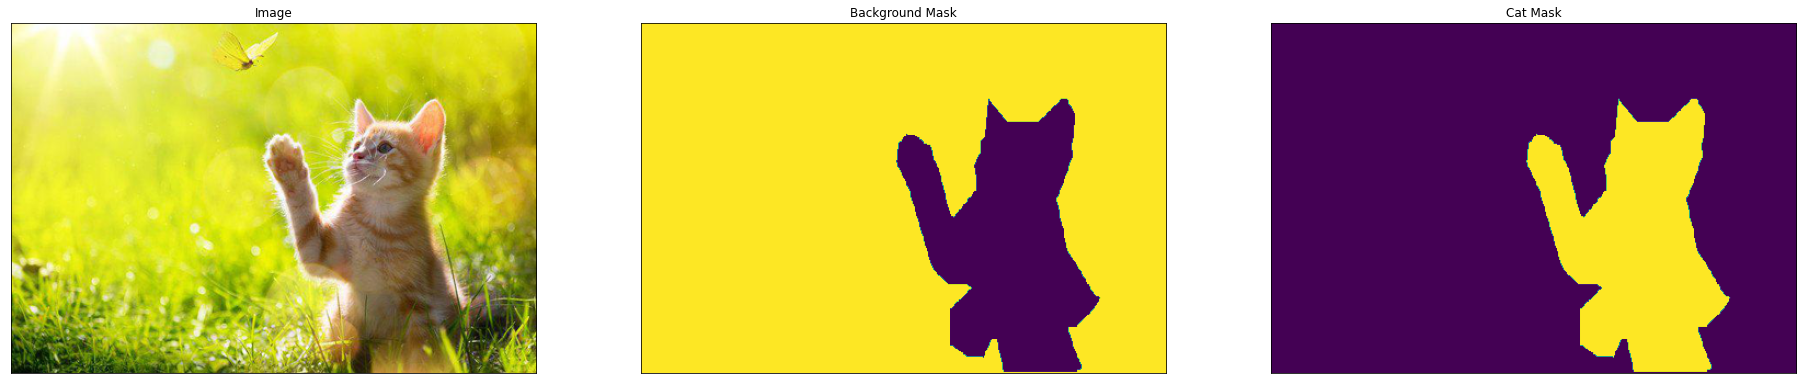

In [21]:
for i in range(0, 2):
  mask = y_valid[i] # get some sample
  visualize(
      image = x_valid[i], 
      background_mask = mask[..., 0].squeeze(),
      cat_mask = mask[..., 1].squeeze(),
  )

## いざ学習！

In [22]:
BACKBORN = 'efficientnetb7'
epoch = 50

model = sm.Unet(BACKBORN, 
                encoder_weights='imagenet', 
                classes = 2, 
                encoder_freeze = True,
                input_shape=(y_image_size, x_image_size, 3)
                )

#最適化手法、損失関数、評価指標
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
dice_loss = sm.losses.DiceLoss()
metrics = [sm.metrics.IOUScore(threshold=0.5)]
#コンパイル
model.compile(optimizer=opt,
              loss=dice_loss,
              metrics=metrics
              ) 

#チェックポイント作成_ベストな重みを保存
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath=checkpoint_filepath,
                            save_weights_only=True,
                            monitor='val_iou_score',
                            mode='max',
                            save_best_only=True
                            )
#学習
history = model.fit(x_train,
                   y_train, 
                   batch_size=2, 
                   epochs=epoch, 
                   validation_data=(x_valid, y_valid),
                   callbacks=[model_checkpoint_callback]
                    )

Epoch 1/50
7/7 [==============================] - 31s 2s/step - loss: 0.4700 - iou_score: 0.4502 - val_loss: 0.7666 - val_iou_score: 0.1462
Epoch 2/50
7/7 [==============================] - 3s 382ms/step - loss: 0.3829 - iou_score: 0.6316 - val_loss: 0.7685 - val_iou_score: 0.1453
Epoch 3/50
7/7 [==============================] - 3s 366ms/step - loss: 0.3153 - iou_score: 0.7135 - val_loss: 0.7661 - val_iou_score: 0.1459
Epoch 4/50
7/7 [==============================] - 4s 691ms/step - loss: 0.2595 - iou_score: 0.7871 - val_loss: 0.7647 - val_iou_score: 0.1464
Epoch 5/50
7/7 [==============================] - 5s 772ms/step - loss: 0.2214 - iou_score: 0.8082 - val_loss: 0.7646 - val_iou_score: 0.1464
Epoch 6/50
7/7 [==============================] - 3s 353ms/step - loss: 0.1972 - iou_score: 0.8345 - val_loss: 0.7660 - val_iou_score: 0.1462
Epoch 7/50
7/7 [==============================] - 5s 738ms/step - loss: 0.1616 - iou_score: 0.8607 - val_loss: 0.7629 - val_iou_score: 0.1480
Epoch 8/

## 学習結果

evaluate loss: 0.06418347358703613
evaluate IoU: 0.8855206966400146


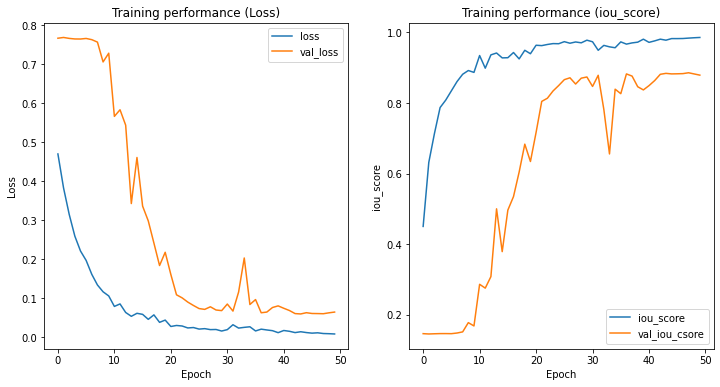

In [26]:
#学習曲線
score = model.evaluate(x_valid, y_valid, verbose=0)
print("evaluate loss: {0[0]}\nevaluate IoU: {0[1]}".format(score))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Training performance (Loss)')
ax[0].plot(history.epoch, history.history['loss'], label='loss')
ax[0].plot(history.epoch, history.history['val_loss'], label='val_loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].legend()

ax[1].set_title('Training performance (iou_score)')
ax[1].plot(history.epoch, history.history['iou_score'], label='iou_score')
ax[1].plot(history.epoch, history.history['val_iou_score'], label='val_iou_csore')
ax[1].set(xlabel='Epoch', ylabel='iou_score')
ax[1].legend(loc='best')
plt.show()

## 学習過程におけるベストモデル（重み）を呼び出す

In [27]:
best_model = sm.Unet(BACKBORN, 
                    #  encoder_weights='imagenet',
                     classes = 2, 
                     encoder_freeze = True,
                     input_shape=(y_image_size, x_image_size, 3)
                    )
best_model.load_weights(checkpoint_filepath)

best_model.compile(optimizer=opt,
                   loss=dice_loss,
                   metrics=metrics
                  )

best_score = best_model.evaluate(x_valid, y_valid, verbose=0)
print("best evaluate loss: {0[0]}\nbest evaluate IoU: {0[1]}".format(best_score))

best evaluate loss: 0.05990588665008545
best evaluate IoU: 0.8928388357162476


## 実際の画像で予測した結果を表示

x_valid:[0, 2, 4]の予測結果を表示
1/1 [==============================] - 0s 62ms/step


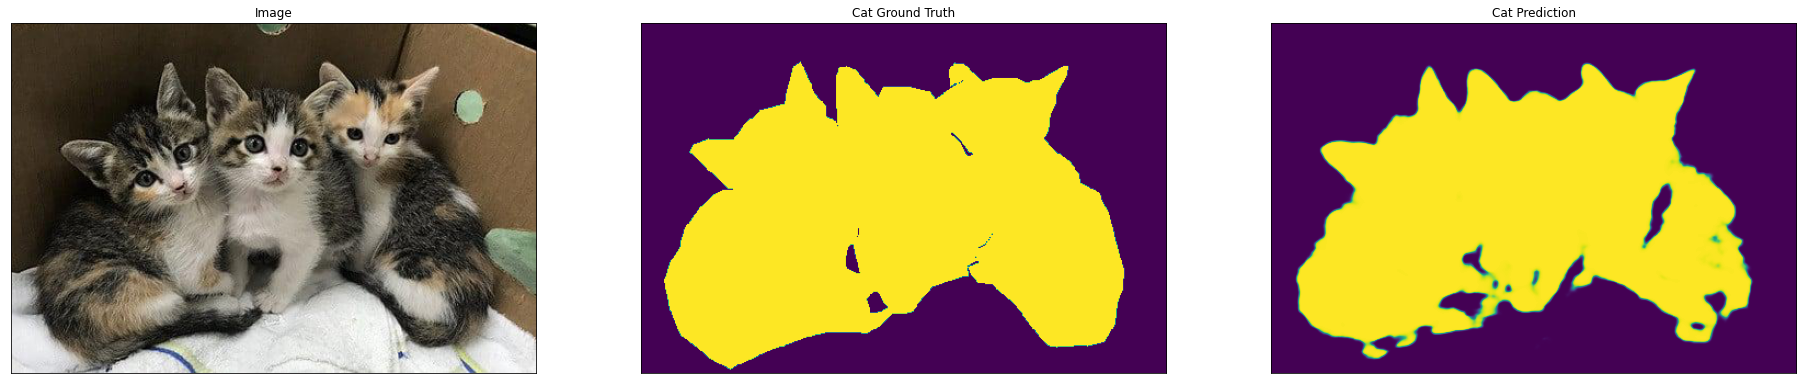

1/1 [==============================] - 0s 70ms/step


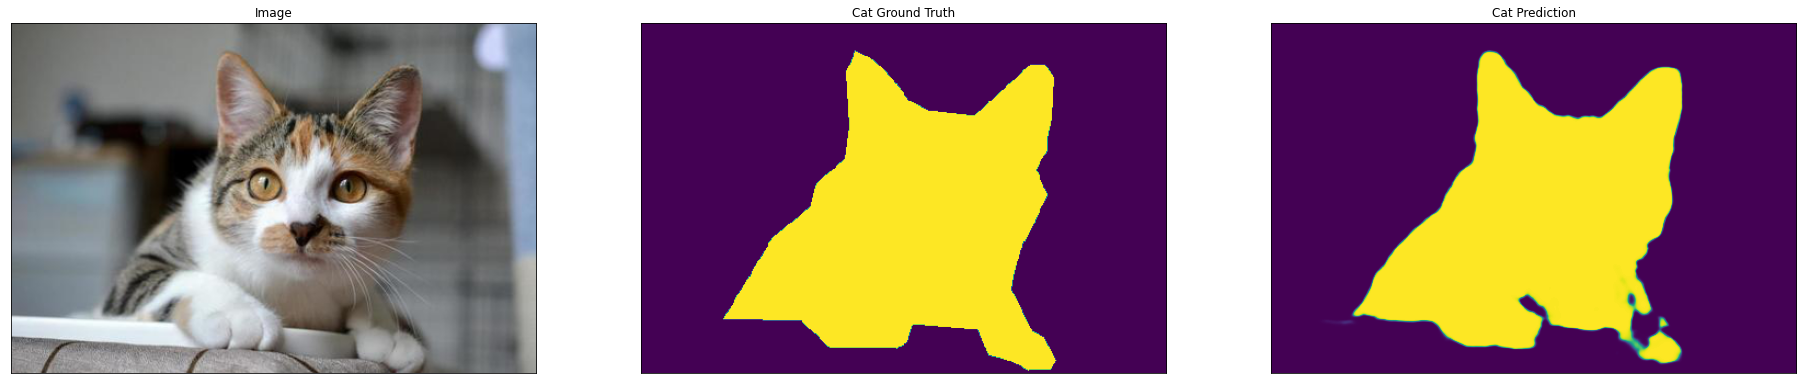

1/1 [==============================] - 0s 58ms/step


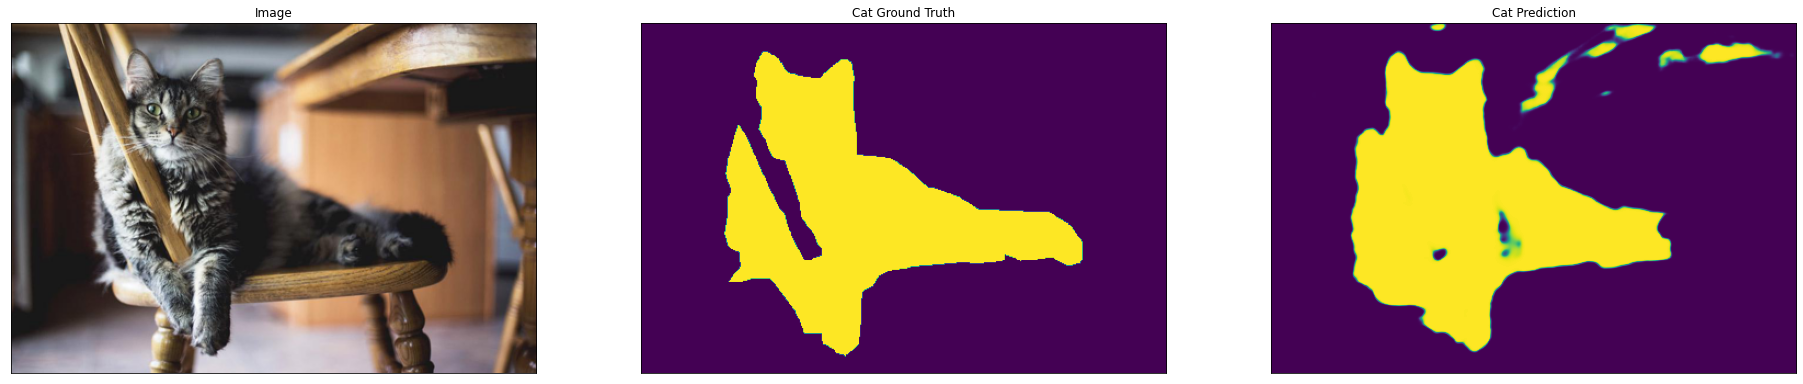

In [36]:
#予測結果の可視化
ids = [0,2,4]#予測するデータ

print(f"x_valid:{ids}の予測結果を表示")
for i in ids:   
    image = x_valid[i]
    gt_mask = y_valid[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = best_model.predict(image)  
    
    visualize(
        image=image.squeeze(),
        cat_Ground_Truth=gt_mask[..., 1].squeeze(),
        cat_Prediction=pr_mask[..., 1].squeeze(),
    )


# わかること
*   全体的に精度高く予測できている
*   ３匹画面内にいる場合も判断できている
*   猫の体が物体で隠されている場合、精度が落ちている


